In [1]:
import re
import tarfile
from pathlib import Path
from time import time
from functools import reduce
from pprint import pprint
from typing import List, Tuple
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

import numpy as np
import pandas as pd
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.models import Sequential
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


In [2]:
#import the already preprocessed dataset 
sdg_df  = pd.read_csv('sdg_classification_data.csv')

In [3]:
validation_df  = pd.read_csv('validation_dataset.csv')

In [4]:
#set the X,y values
X = sdg_df['extracted_title'].fillna(' ').values
y = sdg_df['sdg']

In [5]:
#convert the categorical variable into 0,1 values
y = pd.get_dummies(sdg_df['sdg']).values

In [6]:
#split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

#vectorizer = CountVectorizer()
#vectorizer.fit(X_train)
#X_train = vectorizer.transform(X_train)
#X_test  = vectorizer.transform(X_test)

In [7]:
#tokenize the input variable
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [8]:
#implement padding in the input variable
maxlen = 400

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
X_train[:10]

array([[  37,  151,  845, ...,    0,    0,    0],
       [ 126,  186,    1, ...,    0,    0,    0],
       [   7,  193,  281, ...,    0,    0,    0],
       ...,
       [ 771, 1297,  772, ...,    0,    0,    0],
       [  22,   10,  618, ...,    0,    0,    0],
       [ 448, 2444,    8, ...,    0,    0,    0]])

In [10]:
print(y_test)

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]]


In [11]:
#setting the parameters before creating the model
embedding_dims = 50

nof_filters = 25

kernel_size = 3

hidden_dims = 50

In [12]:
#create the model we are going to use
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(nof_filters, 
                 kernel_size, 
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))

model.add(Activation('relu'))

model.add(Dense(6))
model.add(Activation('softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          269600    
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 25)           7525      
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0

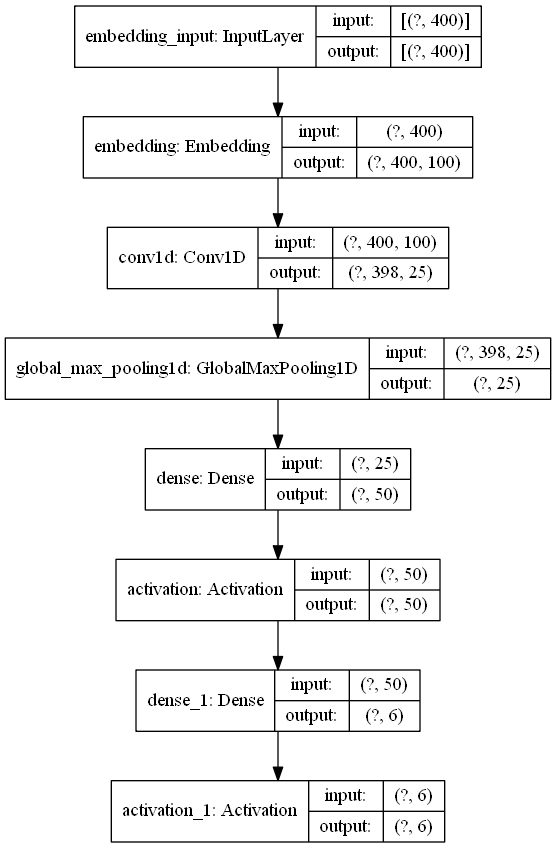

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file='model_plot_cnn.png',
           show_shapes=True,
           show_layer_names=True)

In [14]:
#train our model
train_model = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
12/12 - 1s - loss: 1.7597 - accuracy: 0.2686 - val_loss: 1.6876 - val_accuracy: 0.2978
Epoch 2/10
12/12 - 1s - loss: 1.6185 - accuracy: 0.2771 - val_loss: 1.5384 - val_accuracy: 0.3034
Epoch 3/10
12/12 - 1s - loss: 1.4444 - accuracy: 0.4149 - val_loss: 1.3629 - val_accuracy: 0.5056
Epoch 4/10
12/12 - 1s - loss: 1.2480 - accuracy: 0.7834 - val_loss: 1.1768 - val_accuracy: 0.7640
Epoch 5/10
12/12 - 1s - loss: 1.0239 - accuracy: 0.8326 - val_loss: 0.9543 - val_accuracy: 0.8090
Epoch 6/10
12/12 - 1s - loss: 0.7785 - accuracy: 0.8312 - val_loss: 0.7526 - val_accuracy: 0.8090
Epoch 7/10
12/12 - 1s - loss: 0.5734 - accuracy: 0.8326 - val_loss: 0.6074 - val_accuracy: 0.8146
Epoch 8/10
12/12 - 1s - loss: 0.4276 - accuracy: 0.8664 - val_loss: 0.5217 - val_accuracy: 0.8371
Epoch 9/10
12/12 - 1s - loss: 0.3317 - accuracy: 0.8959 - val_loss: 0.4752 - val_accuracy: 0.8652
Epoch 10/10
12/12 - 1s - loss: 0.2668 - accuracy: 0.9522 - val_loss: 0.4476 - val_accuracy: 0.8652
Training Accuracy: 

In [15]:
#set the X,y values
x_val = validation_df['extracted_title'].fillna(' ').values
y_val = validation_df['sdg']

In [16]:
#convert the categorical variable into 0,1 values
y_val = pd.get_dummies(validation_df['sdg']).values

In [17]:
#tokenize the input variable
#tokenizer_2 = Tokenizer(num_words=50000)
#tokenizer_2.fit_on_texts(x_val)

X_val = tokenizer.texts_to_sequences(x_val)


vocab_size = len(tokenizer.word_index) + 1

In [18]:
print(X_val)

[[312, 417, 134, 1074, 488, 104, 2632, 16, 2633, 122, 1076, 1077, 3], [672, 1085, 673, 36, 113, 674, 365, 14, 3], [1114, 497, 1115, 200, 483, 238, 3, 130], [501, 502, 367, 14, 3, 2, 9, 169, 232, 152], [3, 494, 1140, 3, 89, 172, 3, 204, 378, 14, 3, 1141], [16, 242, 115, 84, 3, 104], [725, 1192, 312, 115, 247, 726, 376, 727, 1193, 248, 136, 50, 75], [3, 885, 239, 2214, 3, 133, 2467, 146, 116, 1098], [733, 79, 117, 527, 1214, 1215, 734, 37, 151, 56, 735, 38], [173, 2590, 49, 14, 3, 235, 2142, 235, 79, 713, 483, 995, 669], [529, 1225, 11, 524, 309], [1226, 153, 26, 396, 233, 742, 383, 244, 249, 529, 737, 43, 114, 67, 120, 23], [8, 51, 185, 649, 128, 37, 270, 223], [8, 20, 933, 2269, 33, 102, 1], [8, 20, 193, 941], [8, 8, 461, 2273, 231, 2274, 2275, 572, 2276, 450, 97, 86], [2322, 558, 128, 2323, 232, 8, 20, 2324, 2325, 2326, 2327, 272], [205, 2340, 962, 1040, 739, 2341, 1041, 4, 659], [8, 51, 363, 1044, 185, 496, 281, 2352, 341, 80, 103], [764, 4, 2370, 12, 2371, 302], [8, 576, 2396, 2397,

In [19]:
#implement padding in the input variable
maxlen = 400

X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [20]:
#Model Evaluation on the Test Set
test_eval = model.evaluate(
    X_val,                  # features
    y_val,
    batch_size=128  
)


1/1 [==============================] - 0s 1000us/step - loss: 0.3008 - accuracy: 0.9192


In [21]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.3008164167404175
Test accuracy: 0.9191918969154358


Run the model including a dropout parameter

In [22]:
#create the model we are going to use
embedding_dim = 100

model_dropout = Sequential()
model_dropout.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_dropout.add(Conv1D(nof_filters, 
                 kernel_size, 
                 padding='valid',
                 activation='relu',
                 strides=1))

model_dropout.add(GlobalMaxPooling1D())
model_dropout.add(Dense(hidden_dims))

model_dropout.add(Dropout(0.4))
model_dropout.add(Activation('relu'))

model_dropout.add(Dense(6))
model_dropout.add(Activation('softmax'))


model_dropout.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          269600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 25)           7525      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

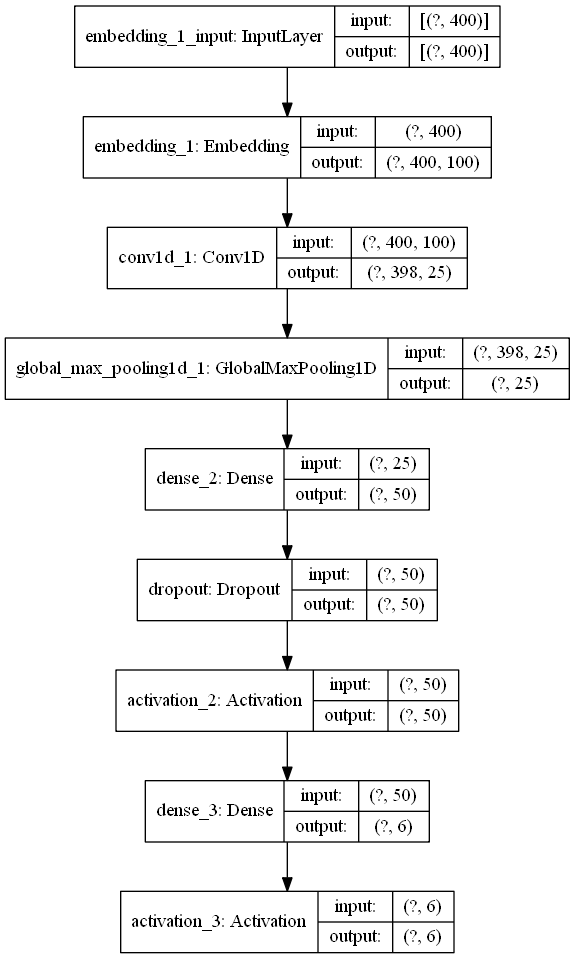

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model_dropout,
           to_file='model_plot_dropout_cnn.png',
           show_shapes=True,
           show_layer_names=True)

In [24]:
#train our model
train_model_dropout = model_dropout.fit(X_train, y_train,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model_dropout.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dropout.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
12/12 - 1s - loss: 1.7256 - accuracy: 0.2954 - val_loss: 1.6461 - val_accuracy: 0.2416
Epoch 2/10
12/12 - 1s - loss: 1.5880 - accuracy: 0.3319 - val_loss: 1.5116 - val_accuracy: 0.2416
Epoch 3/10
12/12 - 1s - loss: 1.4994 - accuracy: 0.3544 - val_loss: 1.4205 - val_accuracy: 0.3596
Epoch 4/10
12/12 - 1s - loss: 1.4099 - accuracy: 0.4824 - val_loss: 1.3444 - val_accuracy: 0.7528
Epoch 5/10
12/12 - 1s - loss: 1.2924 - accuracy: 0.6639 - val_loss: 1.2259 - val_accuracy: 0.7978
Epoch 6/10
12/12 - 1s - loss: 1.1197 - accuracy: 0.7440 - val_loss: 1.0582 - val_accuracy: 0.8090
Epoch 7/10
12/12 - 1s - loss: 0.9162 - accuracy: 0.8017 - val_loss: 0.8733 - val_accuracy: 0.8258
Epoch 8/10
12/12 - 1s - loss: 0.7274 - accuracy: 0.8200 - val_loss: 0.7079 - val_accuracy: 0.8258
Epoch 9/10
12/12 - 1s - loss: 0.5587 - accuracy: 0.8425 - val_loss: 0.5827 - val_accuracy: 0.8596
Epoch 10/10
12/12 - 1s - loss: 0.4306 - accuracy: 0.8734 - val_loss: 0.5024 - val_accuracy: 0.8820
Training Accuracy: 

In [26]:
#Model Evaluation on the Test Set
test_eval_2 = model_dropout.evaluate(
    X_val,                  # features
    y_val,
    batch_size=128  
)

1/1 [==============================] - 0s 2ms/step - loss: 0.4183 - accuracy: 0.8990


In [27]:
print('Test loss:', test_eval_2[0])
print('Test accuracy:', test_eval_2[1])

Test loss: 0.418335884809494
Test accuracy: 0.8989899158477783


In [28]:
import matplotlib.pyplot as plt

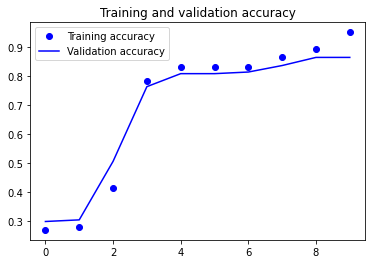

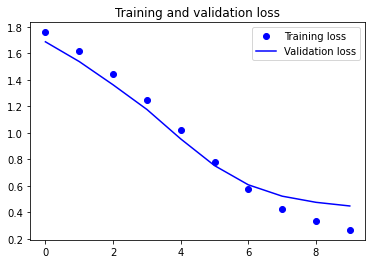

In [29]:
#Plot the accuracy and loss plots between training and validation data:

accuracy = train_model.history['accuracy']
val_accuracy = train_model.history['val_accuracy']
loss =train_model.history['loss']
val_loss = train_model.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
y_test_pred = model.predict_classes(X_val)
y_test_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([5, 0, 0, 2, 0, 0, 3, 0, 1, 0, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2], dtype=int64)

In [31]:
y_val.argmax(axis=1)

array([5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2], dtype=int64)

In [32]:
y_score = model.predict(X_val)

In [33]:
y_score[0]

array([0.13407256, 0.16336486, 0.04223703, 0.18260418, 0.09701619,
       0.3807052 ], dtype=float32)

In [34]:
#function to create roc curve
from scipy import interp
from itertools import cycle


def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

<ipython-input-34-b9e158e82b33>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


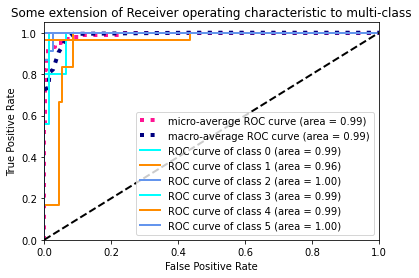

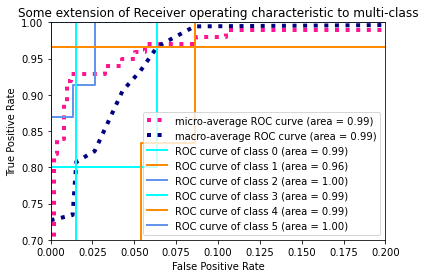

In [35]:
plot_multi_class_roc_auc_curves(nb_classes=6,
                                y_true=y_val,
                                y_pred_score=y_score)

In [36]:
y_pred_class = model.predict_classes(X_val)
y_pred_class

array([5, 0, 0, 2, 0, 0, 3, 0, 1, 0, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2], dtype=int64)

In [37]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_binarize = lb.fit_transform(y_val)

In [38]:
y_test_normal = lb.inverse_transform(y_val)
y_test_normal


array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
 

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
print(classification_report(y_true=np.argmax(y_test_normal,axis = 1),
                            y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       1.00      0.17      0.29         6
           2       0.92      1.00      0.96        23
           3       0.89      1.00      0.94        34
           4       1.00      0.93      0.97        30
           5       1.00      1.00      1.00         1

    accuracy                           0.92        99
   macro avg       0.91      0.82      0.81        99
weighted avg       0.93      0.92      0.90        99



In [41]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

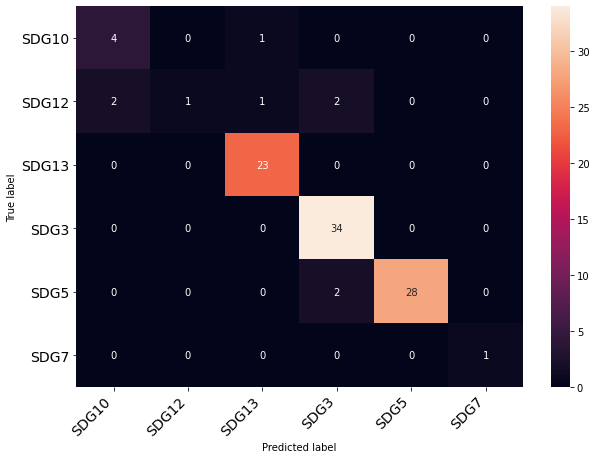

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
SDG10,4,0,1,0,0,0
SDG12,2,1,1,2,0,0
SDG13,0,0,23,0,0,0
SDG3,0,0,0,34,0,0
SDG5,0,0,0,2,28,0
SDG7,0,0,0,0,0,1


In [42]:
#create the confusion matrix using the above function
import seaborn as sns

print_confusion_matrix(y_true=np.argmax(y_test_normal,axis = 1),
                           y_pred=y_pred_class,
                           class_names=['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'])

In [49]:
#import the validation dataset, given by Mr. Fergadis
validation_df = pd.read_csv("validation_dataset.csv")
validation_df

,sdg,extracted_title,extracted_abstract,initial_text
0,SDG7,Solid oxide fuel cell hybrid system: A detaile...,This paper reports a review of an environmenta...,Solid oxide fuel cell hybrid system: A detaile...
1,SDG10,"How do oil prices, macroeconomic factors and p...",The aim of this study is to determine the natu...,"How do oil prices, macroeconomic factors and p..."
2,SDG10,A comprehensive indicator set for measuring mu...,"In this paper, we develop a quantitative indic...",A comprehensive indicator set for measuring mu...
3,SDG10,Foreign direct investment and renewable energy...,Climate change mitigation is a topical issue w...,Foreign direct investment and renewable energy...
4,SDG10,Energy storage and multi energy systems in loc...,This study investigates how a district with a ...,Energy storage and multi energy systems in loc...
...,...,...,...,...
94,SDG13,Dual stresses of flooding and agricultural lan...,Global climate change is leading to a signific...,Dual stresses of flooding and agricultural lan...
95,SDG13,Trend of extreme rainfall events using suitabl...,Kolkata Metropolitan Area (KMA) is one of the ...,Trend of extreme rainfall events using suitabl...
96,SDG13,"Grounding line, ice frontal position and coast...",Over the past 20 years satellite remote sensin...,"Grounding line, ice frontal position and coast..."
97,SDG13,"It's not (just) “the environment, stupid!” Val...",This exploratory mixed-methods study uses in-d...,"It's not (just) “the environment, stupid!” Val..."


In [50]:
titles = validation_df['extracted_title']
titles = titles.tolist()

In [51]:
predicted_titles =[]
for i in titles:
    i = [i]
    seq = tokenizer.texts_to_sequences(i)
    padded = pad_sequences(seq, maxlen=400)
    pred = model.predict(padded)
    labels = sdg_df.sdg.unique()
    predicted_titles.append(labels[np.argmax(pred)])

validation_df['prediction_by_title'] = predicted_titles

validation_df[:20]

,sdg,extracted_title,extracted_abstract,initial_text,prediction_by_title
0,SDG7,Solid oxide fuel cell hybrid system: A detaile...,This paper reports a review of an environmenta...,Solid oxide fuel cell hybrid system: A detaile...,SDG7
1,SDG10,"How do oil prices, macroeconomic factors and p...",The aim of this study is to determine the natu...,"How do oil prices, macroeconomic factors and p...",SDG3
2,SDG10,A comprehensive indicator set for measuring mu...,"In this paper, we develop a quantitative indic...",A comprehensive indicator set for measuring mu...,SDG10
3,SDG10,Foreign direct investment and renewable energy...,Climate change mitigation is a topical issue w...,Foreign direct investment and renewable energy...,SDG13
4,SDG10,Energy storage and multi energy systems in loc...,This study investigates how a district with a ...,Energy storage and multi energy systems in loc...,SDG10
5,SDG10,A review on alternative fuels in future energy...,Transition and decarbonization of the energy s...,A review on alternative fuels in future energy...,SDG10
6,SDG12,Resistance in rejecting solid fuels: Beyond av...,Solid fuels are the primary cooking fuels in a...,Resistance in rejecting solid fuels: Beyond av...,SDG3
7,SDG12,Perpetuating energy poverty: Assessing roadmap...,A growing number of people in Africa still do ...,Perpetuating energy poverty: Assessing roadmap...,SDG10
8,SDG12,Holistic approach for sustainability enhancing...,A novel approach for sustainability enhancemen...,Holistic approach for sustainability enhancing...,SDG12
9,SDG12,Increasing self-consumption of renewable energ...,This paper focuses on a novel energy managemen...,Increasing self-consumption of renewable energ...,SDG10


In [52]:
validation_df["Titles_Matched"] = validation_df.apply(lambda x: x.prediction_by_title == x.sdg, axis = 1)
validation_df

,sdg,extracted_title,extracted_abstract,initial_text,prediction_by_title,Titles_Matched
0,SDG7,Solid oxide fuel cell hybrid system: A detaile...,This paper reports a review of an environmenta...,Solid oxide fuel cell hybrid system: A detaile...,SDG7,True
1,SDG10,"How do oil prices, macroeconomic factors and p...",The aim of this study is to determine the natu...,"How do oil prices, macroeconomic factors and p...",SDG3,False
2,SDG10,A comprehensive indicator set for measuring mu...,"In this paper, we develop a quantitative indic...",A comprehensive indicator set for measuring mu...,SDG10,True
3,SDG10,Foreign direct investment and renewable energy...,Climate change mitigation is a topical issue w...,Foreign direct investment and renewable energy...,SDG13,False
4,SDG10,Energy storage and multi energy systems in loc...,This study investigates how a district with a ...,Energy storage and multi energy systems in loc...,SDG10,True
...,...,...,...,...,...,...
94,SDG13,Dual stresses of flooding and agricultural lan...,Global climate change is leading to a signific...,Dual stresses of flooding and agricultural lan...,SDG13,True
95,SDG13,Trend of extreme rainfall events using suitabl...,Kolkata Metropolitan Area (KMA) is one of the ...,Trend of extreme rainfall events using suitabl...,SDG13,True
96,SDG13,"Grounding line, ice frontal position and coast...",Over the past 20 years satellite remote sensin...,"Grounding line, ice frontal position and coast...",SDG13,True
97,SDG13,"It's not (just) “the environment, stupid!” Val...",This exploratory mixed-methods study uses in-d...,"It's not (just) “the environment, stupid!” Val...",SDG13,True


In [53]:
validation_df.to_csv('validation_dataset_1.csv', encoding='utf-8', index=False)

In [47]:
new_abstract = ['With an increase in the interest in the energy conservation for buildings, and the emergence of many methods and easily-understandable approaches to it, energy conservation has now become the public’s main interest, as compared to in the past when it was only focused upon by experts. This study aims to help the occupants of a building to understand the energy efficiency and consumption of the building by providing them information on the building’s energy efficiency through a mobile application. The energy performance assessment models are proposed on the basis of the actual energy usage and building characteristics such as the architectural scheme and the building equipment. The university buildings in Korea are used as a case to demonstrate the mobile application.']
seq = tokenizer.texts_to_sequences(new_abstract)
padded = pad_sequences(seq, maxlen=400)
pred = model.predict(padded)
labels = sdg_df.sdg.unique()
#labels = sorted(set(sdg_df['sdg']), key=sdg_df['sdg'].index)
print('SDG: ', labels[np.argmax(pred)])

SDG:  SDG7


In [ ]:
import os
import tempfile
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

title_save_path = os.path.join(tmpdir, "CNN_title_model_weights")
tf.saved_model.save(model, title_save_path)